In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_csv('NFL_pbp_2009-2019.csv', low_memory=False)

threshold = 100000
df['field_goal_result'].fillna('none', inplace=True)
dfV2 = df.loc[:, df.isnull().sum() < threshold]
missing_values = dfV2.isnull().sum()

statistical_cols = ['play_id', 'game_id', 'home_team', 'away_team', 'posteam', 
                    'defteam', 'side_of_field', 'yardline_100', 'half_seconds_remaining', 
                    'game_seconds_remaining', 'game_half', 'drive', 'qtr', 'down', 'goal_to_go', 'time', 
                    'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'home_timeouts_remaining', 
                    'away_timeouts_remaining', 'total_home_score',  'total_away_score', 'score_differential', 'home_wp', 'away_wp', 'ep']

game_dynamics_cols = [
    'punt_blocked', 'first_down_rush', 'first_down_pass', 'first_down_penalty', 'third_down_converted',
    'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'interception',
    'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty',
    'tackled_for_loss', 'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit',
    'rush_attempt', 'pass_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'field_goal_result',
    'return_touchdown', 'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt',
    'punt_attempt', 'fumble', 'complete_pass', 'shotgun', 'no_huddle', 'punt_inside_twenty', 'kickoff_inside_twenty']

columns_to_keep = statistical_cols + game_dynamics_cols
dfV3 = dfV2[columns_to_keep]

dfV4 = dfV3.drop(['play_id', 'game_seconds_remaining', 'fumble_forced'], axis=1)

In [2]:
# Indicators for if within last 2 minutes of the half and the whole game
dfV4['close_to_end_of_half'] = (dfV4['half_seconds_remaining'] <= 120).astype(int)
dfV4['close_to_end_of_game'] = ((dfV4['half_seconds_remaining'] <= 120) & (dfV4['game_half'] == 'Half2')).astype(int)

# Indicator for if the touchdown was for the away or home team
dfV4['home_td'] = ((dfV4['touchdown'] == 1) & (dfV4['posteam'] != dfV4['away_team'])).astype(int)
dfV4['away_td'] = ((dfV4['touchdown'] == 1) & (dfV4['posteam'] != dfV4['home_team'])).astype(int)

# Trackers for the difference in both teams' win probability after each play
dfV4['home_wp_change'] = dfV4['home_wp'].diff().fillna(0)
dfV4['away_wp_change'] = dfV4['away_wp'].diff().fillna(0)

# Indicator for turnover
dfV4['turnover'] = (
    (dfV4['safety'] == 1) |
    (dfV4['interception'] == 1) |
    (dfV4['fumble_lost'] == 1) |
    ((dfV4['fourth_down_converted'] == 0) & (dfV4['down'] == 4))
).astype(int)

# Drive time - Added drive ended indicator to help - Manually resets after end of game, half, and change of possession
dfV4['drive_ended'] = (
    (dfV4['posteam'] != dfV4['posteam'].shift(1)) |  
    (dfV4['game_id'] != dfV4['game_id'].shift(1)) |  
    dfV4['desc'].str.contains('END GAME', na=False) |  
    dfV4['desc'].str.contains('END QUARTER', na=False)  
).astype(int)
dfV4['drive'] = (
    (dfV4['posteam'].ne(dfV4['posteam'].shift())) |
    (dfV4['game_id'].ne(dfV4['game_id'].shift()))
).cumsum()
dfV4['drive_time_seconds'] = (
    dfV4.groupby(['game_id', 'drive'])['half_seconds_remaining']
    .transform('first') - dfV4['half_seconds_remaining']
)
dfV4['drive_time_seconds'] = dfV4.apply(
    lambda row: 0 if row['drive_ended'] == 1 else row['drive_time_seconds'], axis=1
)
dfV4['drive_time_seconds'] = dfV4.groupby(['game_id', 'drive'])['drive_time_seconds'].cumsum()

# Indicator for long touchdowns
dfV4['long_td'] = ((dfV4['touchdown'] == 1) & (dfV4['yards_gained'] >= 50)).astype(int)

# Trackers for score differentials and lead changes
dfV4['home_score_differential'] = dfV4['total_home_score'] - dfV4['total_away_score']
dfV4['away_score_differential'] = -dfV4['home_score_differential']
dfV4['lead_change'] = ((dfV4['home_score_differential'].diff() < 0) &
                       (dfV4['home_score_differential'].shift() * dfV4['home_score_differential'] < 0)).astype(int)

# Combining first down indicators
dfV4['first_down'] = ((dfV4['first_down_pass'] == 1) | (dfV4['first_down_rush'] == 1) | (dfV4['first_down_penalty'] == 1)).astype(int)

# Indicators for scoring drives - Removing
dfV4['home_scoring_drive'] = (
    (dfV4['home_td'] == 1) 
).astype(int)
dfV4['away_scoring_drive'] = (
    (dfV4['away_td'] == 1) 
).astype(int)

# Helper for consecutive scoring events - Remove Later!!!!!!!!!!!!!!
dfV4['home_scoring_events'] = (
    (dfV4['posteam'] != dfV4['away_team']) & 
    ((dfV4['home_td'] == 1) | (dfV4['field_goal_result'] == 'made'))
).astype(int)
dfV4['away_scoring_events'] = (
    (dfV4['posteam'] != dfV4['home_team']) & 
    ((dfV4['away_td'] == 1) | (dfV4['field_goal_result'] == 'made'))
).astype(int)

# Consecutive Scoring Events + Helper function 
def calc_consecutive_cumsum_with_game_reset(series, reset_series, game_ids):
    cumsum = 0
    consecutive = []
    prev_game_id = None  
    
    for i in range(len(series)):
        if game_ids[i] != prev_game_id:
            cumsum = 0 
        if reset_series[i] == 1:  
            cumsum = 0
        if series[i] == 1:  
            cumsum += 1
        consecutive.append(cumsum)
        prev_game_id = game_ids[i]  
    return consecutive

dfV4['home_csum_scores'] = calc_consecutive_cumsum_with_game_reset(
    dfV4['home_scoring_events'], dfV4['away_scoring_events'], dfV4['game_id']
)
dfV4['away_csum_scores'] = calc_consecutive_cumsum_with_game_reset(
    dfV4['away_scoring_events'], dfV4['home_scoring_events'], dfV4['game_id']
)


# End of old work

# Fixed Problems
## Quick drive needs to be changed to two features: quick_scoring_drive, and quick_stop. 
### was any drive less than 3 minutes is considered a quick drive and this isnt what i intended

## Consecutive stops for home and away was tracking the number of consecutive plays without letting 
### the other team score, now number of drives* without letting the other team score.

## Drive Numbers were tracking number of plays instead of number of drives for both teams

## probably more, need to look at min, max and averages with dfV3.describe/info

## Counters for consecutive defensive stops for both teams, counting plays before

# New Features
## *Should make another counter for number of offensive penalties for both teams
## *Should make some type of high_leverage_play indicator, converting on third or fourth down in a tied/1 score difference game with little time remaining
## *Should make another indicator for drought_ending_play: team scoring for the first time on a play after being scored on more than twice in a row
## *Need new feature: big_st_play: big special teams play...punt blocked, field goal blocked, turnover off punt?, return_touchdown
## Something to think about: scoring type differentiatior, touchdowns should hold more weight than a field goal

In [3]:

#Fixing Problems below, had to fix ones above also after checking results

#Consecutive defensive stops
dfV4['home_def_stop'] = (
    (dfV4['posteam'] != dfV4['home_team']) &  ((dfV4['punt_attempt'] == 1) |  (dfV4['turnover'] == 1)) & 
    ~dfV4['field_goal_result'].isin(['made'])  
).astype(int)
dfV4['away_def_stop'] = (
    (dfV4['posteam'] != dfV4['away_team']) & ((dfV4['punt_attempt'] == 1) |  (dfV4['turnover'] == 1)) & 
    ~dfV4['field_goal_result'].isin(['made'])
).astype(int)

def calc_consecutive_defensive_stops_with_game_reset(series, reset_series, game_ids):
    cumsum = 0
    consecutive = []
    prev_game_id = None  
    for i in range(len(series)):
        if game_ids[i] != prev_game_id:
            cumsum = 0
        if reset_series[i] == 1:
            cumsum = 0
        if series[i] == 1:
            cumsum += 1
        consecutive.append(cumsum)
        prev_game_id = game_ids[i]  
    return consecutive

dfV4['home_csum_def_stops'] = calc_consecutive_defensive_stops_with_game_reset(
    dfV4['home_def_stop'], dfV4['away_scoring_events'], dfV4['game_id']
)
dfV4['away_csum_def_stops'] = calc_consecutive_defensive_stops_with_game_reset(
    dfV4['away_def_stop'], dfV4['home_scoring_events'], dfV4['game_id']
)

# Home/Away Drive Numbers
dfV4['away_drive_number'] = (
    dfV4.loc[dfV4['posteam'] != dfV4['home_team']]
    .groupby('game_id')['drive_ended'].cumsum()
)
dfV4['home_drive_number'] = (
    dfV4.loc[dfV4['posteam'] == dfV4['home_team']]
    .groupby('game_id')['drive_ended'].cumsum()
)

# High_leverage_play moment, game on the line in a 1 score game
dfV4['high_leverage_moment'] = (
    (dfV4['down'].isin([3, 4])) & 
    (abs(dfV4['score_differential']) <= 8) & 
    (dfV4['qtr'] >= 4)
).astype(int)

# Drought Ending score
dfV4['drought_end_play'] = (
    ((dfV4['away_csum_scores'].shift(1) >= 2) & (dfV4['away_csum_scores'] == 0) & (dfV4['home_scoring_events'] == 1)) |
    ((dfV4['home_csum_scores'].shift(1) >= 2) & (dfV4['home_csum_scores'] == 0) & (dfV4['away_scoring_events'] == 1))
).astype(int)

# Defensive touchdown
dfV4['def_td'] = (
    ((dfV4['fumble'] == 1) & (dfV4['return_touchdown'] == 1)) |
    ((dfV4['interception'] == 1) & (dfV4['return_touchdown'] == 1))
).astype(int)

# Defensive touchdown
dfV4['off_td'] = (
    (dfV4['pass_touchdown'] == 1) | (dfV4['rush_touchdown'] == 1)
).astype(int)

# Special Teams touchdown
dfV4['st_return_td'] = (
    ((dfV4['kickoff_attempt'] == 1) & (dfV4['return_touchdown'] == 1)) | 
    ((dfV4['punt_attempt'] == 1) & (dfV4['return_touchdown'] == 1))  
).astype(int)

# Big special teams play...punt blocked, field goal blocked, return_touchdown, kick recovery, pin team near endzone
dfV4['big_st_play'] = (
    (dfV4['punt_blocked'] == 1) | 
    (dfV4['field_goal_result'] == 'blocked') | 
    (dfV4['own_kickoff_recovery'] == 1) | 
    (dfV4['st_return_td'] == 1) | 
    (dfV4['kickoff_inside_twenty'] == 1) | 
    (dfV4['punt_inside_twenty'] == 1)
).astype(int)

# Scoring type differentiatior, touchdowns should hold more weight than a field goal, other types may hold more weight also
dfV4['scoring_type'] = np.select(
    [
        dfV4['field_goal_result'] == 'made',
        dfV4['off_td'] == 1,
        dfV4['def_td'] == 1,
        dfV4['st_return_td'] == 1,
    ],
    ['fg', 'off_td', 'def_td', 'st_td'],
    default='none'
)

# Indicator for big offensive play
dfV4['big_offensive_play'] = (
        (dfV4['yards_gained'] >= 40) |
        (dfV4['long_td'] == 1) |
        ((dfV4['high_leverage_moment'] == 1) & (dfV4['off_td'] == 1))
).astype(int)

# Indicator for big defensive play
dfV4['big_defensive_play'] = (
    (dfV4['sack'] == 1) |
    (dfV4['tackled_for_loss'] == 1) |
    ((dfV4['high_leverage_moment'] == 1) & (dfV4['def_td'] == 'def_td')) |
    (dfV4['scoring_type'] == 'def_td')
).astype(int)

#Quick Score and Quick Stop
dfV4['quick_score'] = ((dfV4['drive_time_seconds'] < 180) & 
                               ((dfV4['touchdown'] == 1) | (dfV4['field_goal_result'] == 'made'))).astype(int)

dfV4['total_drive_time'] = dfV4.groupby('drive')['drive_time_seconds'].transform('last') 
dfV4['quick_stop'] = ((dfV4['total_drive_time'] < 180) & (dfV4['scoring_type'] == 'none')).astype(int)


# Consecutive first downs
dfV4['home_csum_first_downs'] = 0
dfV4['away_csum_first_downs'] = 0
dfV4['home_csum_first_downs'] = (
    dfV4.groupby(['home_team', 'away_team', 'home_drive_number'])['first_down']
    .cumsum()
    .where(dfV4['posteam'] != 'away_team', 0)
)
dfV4['away_csum_first_downs'] = (
    dfV4.groupby(['home_team', 'away_team', 'away_drive_number'])['first_down']
    .cumsum()
    .where(dfV4['posteam'] != 'home_team', 0)
)

# Testing for mistakes with code, need to check all columns i just made

## New Columns
### /'close_to_end_of_half'-
### /'close_to_end_of_game'-
### /'home_td'
### /'away_td'
### /'home_wp_change'-
### /'away_wp_change'-
### /'big_offensive_play'
### /'big_defensive_play'
### /'turnover'
### /'drive_time_seconds'
### /'long_td'
### /'home_score_differential'
### /'away_score_differential'
### /'lead_change'
### /'first_down'
### /'home_csum_first_downs'
### /'away_csum_first_downs'
### /'home_scoring_drive'....remove
### /'away_scoring_drive'....remove
### /'home_csum_scores'
### /'away_csum_scores'
### /'home_def_stop'
### /'home_csum_def_stop'
### /'away_def_stop'
### /'away_csum_def_stop'
### /'home_drive_number'
### /'away_drive_number'
### /'quick_scoring_drive'
### /'quick_stop'
### /'high_leverage_moment'
### /'drought_end_play'
### /'big_st_play'
### /'scoring_type'

# Home and Away TD, needed to fix the condition from == to !=

In [4]:
print(dfV4[(dfV4['touchdown'] == 1) & (dfV4['posteam'] == 'GB')][['touchdown', 'posteam', 'home_team', 'away_team', 'home_td', 'away_td']])

        touchdown posteam home_team away_team  home_td  away_td
42            1.0      GB       CHI        GB        0        1
4281          1.0      GB        GB       MIN        1        0
4303          1.0      GB        GB       MIN        1        0
4314          1.0      GB        GB       MIN        1        0
6932          1.0      GB        GB       DEN        1        0
7001          1.0      GB        GB       DEN        1        0
7020          1.0      GB        GB       DEN        1        0
8548          1.0      GB        GB       PHI        1        0
8625          1.0      GB        GB       PHI        1        0
8663          1.0      GB        GB       PHI        1        0
13378         1.0      GB       DAL        GB        0        1
13397         1.0      GB       DAL        GB        0        1
13469         1.0      GB       DAL        GB        0        1
13488         1.0      GB       DAL        GB        0        1
16281         1.0      GB        GB     

# Big offensive/defensive plays, both seem to be working...Turnover also working

In [5]:
print(dfV4[dfV4['big_offensive_play'] == 1][['big_offensive_play', 'yards_gained']])
pd.set_option('display.max_colwidth', None)
dfV4.head(600)[dfV4.head(600)['big_defensive_play'] == 1][['big_offensive_play', 'turnover', 'desc']]

        big_offensive_play  yards_gained
39                       1          47.0
373                      1          48.0
411                      1          69.0
428                      1          51.0
479                      1          53.0
708                      1          38.0
903                      1          49.0
918                      1          47.0
929                      1          83.0
950                      1          49.0
975                      1          60.0
1076                     1          68.0
1083                     1          42.0
1105                     1          49.0
1120                     1          41.0
1129                     1          69.0
1255                     1          47.0
1337                     1          51.0
1365                     1          75.0
1508                     1          55.0
1512                     1          63.0
1658                     1          42.0
1670                     1          55.0
1709            

,big_offensive_play,turnover,desc
3,0,0,"(13:45) (Shotgun) A.Rodgers sacked at GB 15 for -10 yards (R.Robertson-Harris). Penalty on GB-L.Taylor, Offensive Holding, declined."
11,0,0,(10:25) (Shotgun) M.Trubisky sacked at GB 45 for -6 yards (B.Martinez).
15,0,0,(8:51) (Shotgun) A.Rodgers sacked at GB 5 for -7 yards (L.Floyd).
48,0,0,"(11:36) C.Patterson right guard to GB 41 for -2 yards (A.Amos; K.Clark). Penalty on CHI-J.Daniels, Offensive Holding, declined."
56,0,0,(7:03) (Shotgun) J.Williams left tackle to GB 34 for -1 yards (R.Robertson-Harris).
57,0,0,(6:19) (Shotgun) A.Rodgers sacked at GB 26 for -8 yards (A.Hicks).
62,0,0,(3:46) (Shotgun) M.Trubisky sacked at CHI 16 for -1 yards (Z.Smith).
76,0,0,(:38) (Shotgun) M.Trubisky sacked at CHI 16 for -2 yards (K.King).
96,0,0,(11:43) (Shotgun) A.Rodgers sacked at CHI 47 for -7 yards (L.Floyd).
100,0,0,(9:47) (Shotgun) M.Trubisky sacked at CHI 19 for 0 yards (sack split by P.Smith and K.Clark).


# Close to end of half/game working

In [6]:
dfV4.head(300)[dfV4.head(300)['close_to_end_of_half'] == 1][['close_to_end_of_half', 'close_to_end_of_game', 'half_seconds_remaining', 'game_half']]

,close_to_end_of_half,close_to_end_of_game,half_seconds_remaining,game_half
67,1,0,120.0,Half1
68,1,0,120.0,Half1
69,1,0,114.0,Half1
70,1,0,87.0,Half1
71,1,0,64.0,Half1
72,1,0,60.0,Half1
73,1,0,55.0,Half1
74,1,0,55.0,Half1
75,1,0,43.0,Half1
76,1,0,38.0,Half1


# quick_score, drive_time_seconds, and long_td
## long td works, quick scoring drive works
## drive_time_seconds is wrong: showing negative drive times, not resetting at end of game as new drive
## Fixed!! Made drive_ended indicator and manually reset at end of game and end of half

In [9]:
dfV4.head(10000)[dfV4.head(10000)['quick_score'] == 1][['scoring_type', 'drive_time_seconds', 'long_td', 'yards_gained']]

,scoring_type,drive_time_seconds,long_td,yards_gained
216,fg,163.0,0,0.0
221,off_td,17.0,0,5.0
250,fg,104.0,0,0.0
322,off_td,23.0,0,2.0
357,off_td,0.0,0,1.0
411,off_td,84.0,1,69.0
479,off_td,12.0,1,53.0
495,off_td,0.0,0,2.0
564,def_td,0.0,0,0.0
739,off_td,77.0,0,23.0


In [10]:
dfV4.head(200)[['drive_time_seconds', 'half_seconds_remaining', 'posteam' ,'desc']]

,drive_time_seconds,half_seconds_remaining,posteam,desc
0,0.0,1800.0,GB,"E.Pineiro kicks 65 yards from CHI 35 to end zone, Touchback."
1,0.0,1800.0,GB,(15:00) A.Jones left tackle to GB 25 for no gain (R.Smith).
2,27.0,1773.0,GB,(14:33) A.Rodgers pass short left to A.Jones to GB 25 for no gain (R.Smith).
3,102.0,1725.0,GB,"(13:45) (Shotgun) A.Rodgers sacked at GB 15 for -10 yards (R.Robertson-Harris). Penalty on GB-L.Taylor, Offensive Holding, declined."
4,207.0,1695.0,GB,"(13:15) (Punt formation) J.Scott punts 53 yards to CHI 32, Center-H.Bradley. T.Cohen pushed ob at CHI 43 for 11 yards (A.Amos)."
5,0.0,1681.0,CHI,"(13:01) (Shotgun) T.Cohen FUMBLES (Aborted) at CHI 37, and recovers at CHI 39. PENALTY on GB-K.Clark, Defensive Holding, 5 yards, enforced at CHI 43 - No Play."
6,28.0,1653.0,CHI,(12:33) (Shotgun) M.Davis left guard to GB 47 for 5 yards (K.Clark; D.Lowry).
7,91.0,1618.0,CHI,(11:58) (Shotgun) M.Trubisky pass incomplete short left to A.Robinson (P.Smith).
8,158.0,1614.0,CHI,(11:54) (Shotgun) M.Trubisky scrambles right tackle to GB 40 for 7 yards (R.Greene).
9,267.0,1572.0,CHI,(11:12) (Shotgun) M.Trubisky pass incomplete short left to T.Cohen.


# lead change, score differentials work
# home_scoring_drive and away didnt work, fixed them and realized theyre the same as away and home td 
##### Remove home_scoring_drive and away_scoring_drive ##########

In [11]:
dfV4.head(10000)[dfV4.head(10000)['lead_change'] == 1][['home_score_differential', 'away_score_differential', 'home_td', 'home_scoring_drive', 'away_td', 'away_scoring_drive']]

,home_score_differential,away_score_differential,home_td,home_scoring_drive,away_td,away_scoring_drive
42,-3,3,0,0,1,1
1294,-3,3,0,0,1,1
1644,-2,2,0,0,1,1
1670,-2,2,0,0,1,1
1849,-5,5,0,0,1,1
2936,-3,3,0,0,1,1
2975,-4,4,0,0,1,1
3535,-2,2,0,0,1,1
3670,-3,3,0,0,1,1
4870,-3,3,0,0,1,1


# first down works
# consecutive first downs for away and home, home and away drive number both not working
# consecutive first downs always 0, drive numbers always 1
# FIXED!!!! - home and drive number needed different conditions, csum first downs needed to change == to != and change the logic to track drive

In [12]:
dfV4.head(1000)[['home_team', 'away_team', 'home_csum_first_downs', 'away_csum_first_downs', 'home_drive_number', 'away_drive_number', 'drive', 'desc']]

,home_team,away_team,home_csum_first_downs,away_csum_first_downs,home_drive_number,away_drive_number,drive,desc
0,CHI,GB,NaN,0.0,NaN,1.0,1,"E.Pineiro kicks 65 yards from CHI 35 to end zone, Touchback."
1,CHI,GB,NaN,0.0,NaN,1.0,1,(15:00) A.Jones left tackle to GB 25 for no gain (R.Smith).
2,CHI,GB,NaN,0.0,NaN,1.0,1,(14:33) A.Rodgers pass short left to A.Jones to GB 25 for no gain (R.Smith).
3,CHI,GB,NaN,0.0,NaN,1.0,1,"(13:45) (Shotgun) A.Rodgers sacked at GB 15 for -10 yards (R.Robertson-Harris). Penalty on GB-L.Taylor, Offensive Holding, declined."
4,CHI,GB,NaN,0.0,NaN,1.0,1,"(13:15) (Punt formation) J.Scott punts 53 yards to CHI 32, Center-H.Bradley. T.Cohen pushed ob at CHI 43 for 11 yards (A.Amos)."
5,CHI,GB,1.0,NaN,1.0,NaN,2,"(13:01) (Shotgun) T.Cohen FUMBLES (Aborted) at CHI 37, and recovers at CHI 39. PENALTY on GB-K.Clark, Defensive Holding, 5 yards, enforced at CHI 43 - No Play."
6,CHI,GB,1.0,NaN,1.0,NaN,2,(12:33) (Shotgun) M.Davis left guard to GB 47 for 5 yards (K.Clark; D.Lowry).
7,CHI,GB,1.0,NaN,1.0,NaN,2,(11:58) (Shotgun) M.Trubisky pass incomplete short left to A.Robinson (P.Smith).
8,CHI,GB,2.0,NaN,1.0,NaN,2,(11:54) (Shotgun) M.Trubisky scrambles right tackle to GB 40 for 7 yards (R.Greene).
9,CHI,GB,2.0,NaN,1.0,NaN,2,(11:12) (Shotgun) M.Trubisky pass incomplete short left to T.Cohen.


In [13]:
dfV4.head(1000)[['home_team' , 'away_team', 'posteam', 'first_down', 'home_drive_number', 'away_drive_number', 'home_csum_first_downs', 'away_csum_first_downs']]

,home_team,away_team,posteam,first_down,home_drive_number,away_drive_number,home_csum_first_downs,away_csum_first_downs
0,CHI,GB,GB,0,NaN,1.0,NaN,0.0
1,CHI,GB,GB,0,NaN,1.0,NaN,0.0
2,CHI,GB,GB,0,NaN,1.0,NaN,0.0
3,CHI,GB,GB,0,NaN,1.0,NaN,0.0
4,CHI,GB,GB,0,NaN,1.0,NaN,0.0
5,CHI,GB,CHI,1,1.0,NaN,1.0,NaN
6,CHI,GB,CHI,0,1.0,NaN,1.0,NaN
7,CHI,GB,CHI,0,1.0,NaN,1.0,NaN
8,CHI,GB,CHI,1,1.0,NaN,2.0,NaN
9,CHI,GB,CHI,0,1.0,NaN,2.0,NaN


# 'home_csum_scores', 'away_csum_scores', 'scoring_type'
## Scoring type works
## csum scores count to 1 and then reset 0 correctly but never goes past 1
## FIXED!!! added in field goals for all the scoring types, changed the logic to get the cumulative sum and reset to 0 if the other team csum increments

In [14]:
dfV4.head(3000)[dfV4.head(3000)['scoring_type'] != 'none'][['posteam', 'home_td', 'home_csum_scores', 'away_td', 'away_csum_scores', 'scoring_type']]

,posteam,home_td,home_csum_scores,away_td,away_csum_scores,scoring_type
22,CHI,0,1,0,0,fg
42,GB,0,0,1,1,off_td
145,GB,0,0,0,2,fg
216,LA,0,0,0,1,fg
221,LA,0,0,1,2,off_td
250,LA,0,0,0,3,fg
263,CAR,0,1,0,0,fg
273,LA,0,0,0,1,fg
283,CAR,1,1,0,0,off_td
301,LA,0,0,1,1,off_td


## Need to look at if return_touchdowns indicate home or away td... It does indicate :)

In [15]:
dfV4.head(10000)[dfV4.head(10000)['return_touchdown'] == 1][['home_td','away_td', 'scoring_type']]

,home_td,away_td,scoring_type
564,0,1,def_td
1407,1,0,def_td
1812,0,1,def_td
1853,1,0,def_td
1917,1,0,def_td
4754,1,0,def_td
4760,1,0,def_td
6065,0,1,st_td
6382,1,0,def_td
7828,1,0,st_td


# *'home_def_stop_drive', *'home_csum_def_stop_drive', *'away_def_stop_drive', *'away_csum_def_stop_drive'
## Problems, cumulative sum not consecutive stops, also counting field goal as a stop but i do not want that
## Fixed consecutive fairly easily since i have dealt with that before, field goal became incredibly time wasting and frustrating
## FIXED!!!!! Finally found a condition that fully excludes field goals being made from being a defensive stop
## fixed this with changing one or multiple explicit condition checks to checking for made field goal and excluding the row from the feature indicator

In [16]:
dfV4.head(200)[['posteam', 'down', 'home_def_stop','home_csum_def_stops', 'away_def_stop','away_csum_def_stops','scoring_type', 'field_goal_result']]

,posteam,down,home_def_stop,home_csum_def_stops,away_def_stop,away_csum_def_stops,scoring_type,field_goal_result
0,GB,NaN,0,0,0,0,none,none
1,GB,1.0,0,0,0,0,none,none
2,GB,2.0,0,0,0,0,none,none
3,GB,3.0,0,0,0,0,none,none
4,GB,4.0,1,1,0,0,none,none
5,CHI,1.0,0,1,0,0,none,none
6,CHI,1.0,0,1,0,0,none,none
7,CHI,2.0,0,1,0,0,none,none
8,CHI,3.0,0,1,0,0,none,none
9,CHI,1.0,0,1,0,0,none,none


# Quick stop, worked well but needed to change logic to make sure scores werent being counted as stops, just added one more condition

In [17]:
dfV4.head(1000)[dfV4.head(1000)['quick_stop'] == 1][['posteam','total_drive_time','touchdown', 'turnover', 'home_def_stop', 'away_def_stop']]

,posteam,total_drive_time,touchdown,turnover,home_def_stop,away_def_stop
13,GB,149.0,0.0,0,0,0
14,GB,149.0,0.0,0,0,0
15,GB,149.0,0.0,0,0,0
16,GB,149.0,0.0,1,1,0
23,GB,95.0,0.0,0,0,0
24,GB,95.0,0.0,0,0,0
25,GB,95.0,0.0,0,0,0
26,GB,95.0,0.0,0,0,0
27,GB,95.0,0.0,1,1,0
36,NaN,0.0,NaN,0,0,0


# High Leverage Moment, worked well just had to fix a conditional parentheses

In [18]:
dfV4.head(2000)[dfV4.head(2000)['high_leverage_moment'] == 1][['qtr', 'down', 'total_home_score', 'total_away_score']]

,qtr,down,total_home_score,total_away_score
123,4,4.0,3,7
132,4,3.0,3,7
133,4,4.0,3,7
141,4,3.0,3,7
144,4,3.0,3,7
145,4,4.0,3,10
153,4,3.0,3,10
156,4,3.0,3,10
159,4,3.0,3,10
163,4,3.0,3,10


# Drought ending play
## didnt work at first but quick logic fix, had to account for csum changing to 0 when other team scored so now check previous row csum

In [19]:
dfV4.head(2000)[dfV4.head(2000)['drought_end_play'] == 1][['total_home_score', 'total_away_score', 'home_td', 'away_td' , 'scoring_type']]

,total_home_score,total_away_score,home_td,away_td,scoring_type
263,3,13,0,0,fg
338,20,29,0,1,off_td
428,6,17,1,0,off_td
546,32,26,0,1,off_td
867,28,6,0,1,off_td
955,3,28,0,0,fg
992,9,42,1,0,off_td
1097,6,10,1,0,off_td
1206,19,37,1,0,off_td
1362,12,15,1,0,off_td


# Big special teams play, it works very well but one problem:
## return_touchdown accounts for punt, kickoff, interception, and fumble returns... I need to split punt and kickoff only into this, and now can make
## a defensive touchdown category much easier!!

In [20]:
dfV4.head(2000)[dfV4.head(2000)['big_st_play'] == 1][['play_type', 'yrdln', 'field_goal_result', 'punt_blocked', 'touchdown', 'return_touchdown', 'desc']]

,play_type,yrdln,field_goal_result,punt_blocked,touchdown,return_touchdown,desc
12,punt,GB 45,none,0.0,0.0,0.0,"(9:47) (Punt formation) P.O'Donnell punts 33 yards to GB 12, Center-P.Scales, fair catch by T.Davis."
27,punt,GB 45,none,0.0,0.0,0.0,"(3:20) (Punt formation) J.Scott punts 47 yards to CHI 8, Center-H.Bradley, fair catch by T.Cohen. PENALTY on CHI-J.Iyiegbuniwe, Offensive Holding, 4 yards, enforced at CHI 8."
49,punt,GB 41,none,0.0,0.0,0.0,"(11:20) (Punt formation) P.O'Donnell punts 37 yards to GB 4, Center-P.Scales, downed by CHI-J.Iyiegbuniwe."
58,punt,GB 26,none,0.0,0.0,0.0,"(5:37) (Punt formation) J.Scott punts 63 yards to CHI 11, Center-H.Bradley, downed by GB-W.Redmond."
74,punt,GB 49,none,0.0,0.0,0.0,"(:55) (Punt formation) J.Scott punts 36 yards to CHI 15, Center-H.Bradley, downed by GB-H.Bradley."
97,punt,CHI 47,none,0.0,0.0,0.0,"(10:58) (Punt formation) J.Scott punts 37 yards to CHI 10, Center-H.Bradley, fair catch by T.Cohen."
123,punt,MID 50,none,0.0,0.0,0.0,"(15:00) (Punt formation) J.Scott punts 37 yards to CHI 13, Center-H.Bradley, fair catch by T.Cohen."
133,punt,CHI 36,none,0.0,0.0,0.0,"(11:55) (Punt formation) P.O'Donnell punts 53 yards to GB 11, Center-P.Scales, fair catch by T.Davis. PENALTY on GB-T.Brown, Illegal Blindside Block, 5 yards, enforced at GB 11."
229,punt,CAR 39,none,0.0,0.0,0.0,"(9:43) M.Palardy punts 58 yards to LA 3, Center-J.Jansen. J.Natson to LA 6 for 3 yards (N.Jamerson). PENALTY on LA-S.Ebukam, Unnecessary Roughness, 3 yards, enforced at LA 6."
320,punt,LA 23,none,1.0,0.0,0.0,"(13:45) J.Hekker punt is BLOCKED by J.Carter, Center-J.McQuaide, RECOVERED by CAR-R.Bonnafon at LA 9. R.Bonnafon to LA 5 for 4 yards (J.Hekker)."


# Split return touchdowns in scoring type so we can differentiate offensive, defensive, and special teams touchdowns
## Not working exactly, row 6065 should be st_return_td
## Fixed by creating off_td feature for differentiation

In [21]:
dfV4.head(20000)[dfV4.head(20000)['return_touchdown'] == 1][['play_type', 'touchdown']]

,play_type,touchdown
564,pass,1.0
1407,pass,1.0
1812,pass,1.0
1853,pass,1.0
1917,pass,1.0
4754,pass,1.0
4760,pass,1.0
6065,kickoff,1.0
6382,pass,1.0
7828,punt,1.0


In [22]:
dfV4.head(20000)[dfV4.head(20000)['return_touchdown'] == 1][['scoring_type']]

,scoring_type
564,def_td
1407,def_td
1812,def_td
1853,def_td
1917,def_td
4754,def_td
4760,def_td
6065,st_td
6382,def_td
7828,st_td


# Removing Redundant Features + Helper features i created
## 'home_scoring_drive', 'away_scoring_drive','home_scoring_events','away_scoring_events', 'total_drive_time'
## old features i used that no longer are needed: 'return_td', 'touchdown', 'desc', 'drive', etc

# Need to remove:
## all rows with down == nan (will remove all rows for halftime, end of game, o_play, etc that have no real data that is useful)

In [36]:
print(dfV4.columns.tolist())
columns_to_remove = [
    'ep', 'punt_blocked', 'first_down_rush', 'first_down_pass', 'first_down_penalty', 
    'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
    'fourth_down_failed', 'incomplete_pass', 'interception', 'fumble_not_forced', 
    'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty', 'tackled_for_loss', 
    'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit', 
    'rush_attempt', 'pass_attempt', 'sack', 'extra_point_attempt', 'two_point_attempt', 
    'field_goal_attempt', 'kickoff_attempt', 'punt_attempt', 'fumble', 'pass_touchdown', 'rush_touchdown'
    'complete_pass', 'shotgun', 'home_scoring_drive', 'away_scoring_drive','home_scoring_events','away_scoring_events',
    'rush_touchdown', 'field_goal_result', 'return_touchdown', 'complete_pass', 'no_huddle', 'punt_inside_twenty', 'kickoff_inside_twenty',
    'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'side_of_field', 'yardline_100', 'desc', 'drive', 'game_half', 'drive_ended', 'drive_time_seconds',
    'touchdown', 'score_differential', 'total_drive_time', 'game_id'
]

dfV5 = dfV4.drop(columns=columns_to_remove, errors='ignore')
dfV5 = dfV5.dropna(subset=['down'])
print(dfV5.columns.tolist())

['game_id', 'home_team', 'away_team', 'posteam', 'defteam', 'side_of_field', 'yardline_100', 'half_seconds_remaining', 'game_half', 'drive', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'home_timeouts_remaining', 'away_timeouts_remaining', 'total_home_score', 'total_away_score', 'score_differential', 'home_wp', 'away_wp', 'ep', 'punt_blocked', 'first_down_rush', 'first_down_pass', 'first_down_penalty', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'interception', 'fumble_not_forced', 'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty', 'tackled_for_loss', 'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit', 'rush_attempt', 'pass_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'field_goal_result', 'return_touchdown', 'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt', 'punt_attempt', 

In [37]:
dfV5.describe()

,half_seconds_remaining,qtr,down,goal_to_go,yards_gained,home_timeouts_remaining,away_timeouts_remaining,total_home_score,total_away_score,home_wp,away_wp,close_to_end_of_half,close_to_end_of_game,home_td,away_td,home_wp_change,away_wp_change,turnover,long_td,home_score_differential,away_score_differential,lead_change,first_down,home_csum_scores,away_csum_scores,home_def_stop,away_def_stop,home_csum_def_stops,away_csum_def_stops,away_drive_number,home_drive_number,high_leverage_moment,drought_end_play,def_td,off_td,st_return_td,big_st_play,big_offensive_play,big_defensive_play,quick_score,quick_stop,home_csum_first_downs,away_csum_first_downs
count,422609.000000,422609.000000,422609.000000,422069.000000,422396.000000,422609.000000,422609.000000,422609.000000,422609.000000,4.220620e+05,4.220620e+05,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,210429.000000,212180.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,422609.000000,212180.000000,210429.000000
mean,837.158042,2.560923,1.998732,0.057270,4.601623,2.567271,2.541943,11.616149,10.306506,5.351600e-01,4.648400e-01,0.121791,0.050735,0.017543,0.015923,0.000400,-0.000306,0.115795,0.002354,1.309643,-1.309643,0.002634,0.260319,0.760114,0.663327,0.049074,0.046745,1.470747,1.335350,8.762718,6.900174,0.042235,0.010102,0.001301,0.030967,0.000317,0.023118,0.010412,0.066182,0.013630,0.180609,4.342596,3.586065
std,542.820958,1.129849,1.005288,0.232359,8.369261,0.738671,0.759141,10.067926,9.499468,2.851624e-01,2.851624e-01,0.327045,0.219456,0.131285,0.125176,0.042217,0.045855,0.319979,0.048465,10.849491,10.849491,0.051251,0.438809,1.068089,0.979785,0.216022,0.211093,1.841095,1.738812,5.584996,4.029080,0.201126,0.099998,0.036052,0.173229,0.017804,0.150279,0.101504,0.248600,0.115948,0.384694,4.900885,4.085986
min,0.000000,1.000000,1.000000,0.000000,-38.000000,-4.000000,-1.000000,0.000000,0.000000,2.220446e-16,2.220446e-16,0.000000,0.000000,0.000000,0.000000,-0.996422,-0.999987,0.000000,0.000000,-49.000000,-59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,341.000000,2.000000,1.000000,0.000000,0.000000,2.000000,2.000000,3.000000,3.000000,3.285650e-01,2.283470e-01,0.000000,0.000000,0.000000,0.000000,-0.013996,-0.014723,0.000000,0.000000,-4.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,825.000000,3.000000,2.000000,0.000000,2.000000,3.000000,3.000000,10.000000,7.000000,5.337684e-01,4.662316e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000
75%,1307.000000,4.000000,3.000000,0.000000,7.000000,3.000000,3.000000,17.000000,17.000000,7.716530e-01,6.714350e-01,0.000000,0.000000,0.000000,0.000000,0.014717,0.014042,0.000000,0.000000,7.000000,4.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,2.000000,13.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,5.000000
max,1800.000000,5.000000,4.000000,1.000000,99.000000,3.000000,3.000000,61.000000,59.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,0.993688,0.999995,1.000000,1.000000,59.000000,49.000000,1.000000,1.000000,9.000000,8.000000,1.000000,1.000000,14.000000,13.000000,31.000000,23.000000,1.000000

In [38]:
dfV5.head(100)

,home_team,away_team,posteam,defteam,half_seconds_remaining,qtr,down,goal_to_go,play_type,yards_gained,home_timeouts_remaining,away_timeouts_remaining,total_home_score,total_away_score,home_wp,away_wp,close_to_end_of_half,close_to_end_of_game,home_td,away_td,home_wp_change,away_wp_change,turnover,long_td,home_score_differential,away_score_differential,lead_change,first_down,home_csum_scores,away_csum_scores,home_def_stop,away_def_stop,home_csum_def_stops,away_csum_def_stops,away_drive_number,home_drive_number,high_leverage_moment,drought_end_play,def_td,off_td,st_return_td,big_st_play,scoring_type,big_offensive_play,big_defensive_play,quick_score,quick_stop,home_csum_first_downs,away_csum_first_downs
1,CHI,GB,GB,CHI,1800.0,1,1.0,0.0,run,0.0,3,3,0,0,0.499993,0.500007,0,0,0,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,1.0,NaN,0,0,0,0,0,0,none,0,0,0,0,NaN,0.0
2,CHI,GB,GB,CHI,1773.0,1,2.0,0.0,pass,0.0,3,3,0,0,0.520654,0.479346,0,0,0,0,0.020660,-0.020660,0,0,0,0,0,0,0,0,0,0,0,0,1.0,NaN,0,0,0,0,0,0,none,0,0,0,0,NaN,0.0
3,CHI,GB,GB,CHI,1725.0,1,3.0,0.0,pass,-10.0,3,3,0,0,0.546742,0.453258,0,0,0,0,0.026088,-0.026088,0,0,0,0,0,0,0,0,0,0,0,0,1.0,NaN,0,0,0,0,0,0,none,0,1,0,0,NaN,0.0
4,CHI,GB,GB,CHI,1695.0,1,4.0,0.0,punt,0.0,3,3,0,0,0.613673,0.386327,0,0,0,0,0.066931,-0.066931,1,0,0,0,0,0,0,0,1,0,1,0,1.0,NaN,0,0,0,0,0,0,none,0,0,0,0,NaN,0.0
5,CHI,GB,CHI,GB,1681.0,1,1.0,0.0,no_play,0.0,3,3,0,0,0.556110,0.443890,0,0,0,0,-0.057563,0.057563,0,0,0,0,0,1,0,0,0,0,1,0,NaN,1.0,0,0,0,0,0,0,none,0,0,0,0,1.0,NaN
6,CHI,GB,CHI,GB,1653.0,1,1.0,0.0,run,5.0,3,3,0,0,0.569501,0.430499,0,0,0,0,0.013391,-0.013391,0,0,0,0,0,0,0,0,0,0,1,0,NaN,1.0,0,0,0,0,0,0,none,0,0,0,0,1.0,NaN
7,CHI,GB,CHI,GB,1618.0,1,2.0,0.0,pass,0.0,3,3,0,0,0.572831,0.427169,0,0,0,0,0.003330,-0.003330,0,0,0,0,0,0,0,0,0,0,1,0,NaN,1.0,0,0,0,0,0,0,none,0,0,0,0,1.0,NaN
8,CHI,GB,CHI,GB,1614.0,1,3.0,0.0,run,7.0,3,3,0,0,0.546933,0.453067,0,0,0,0,-0.025898,0.025898,0,0,0,0,0,1,0,0,0,0,1,0,NaN,1.0,0,0,0,0,0,0,none,0,0,0,0,2.0,NaN
9,CHI,GB,CHI,GB,1572.0,1,1.0,0.0,pass,0.0,3,3,0,0,0.597515,0.402485,0,0,0,0,0.050583,-0.050583,0,0,0,0,0,0,0,0,0,0,1,0,NaN,1.0,0,0,0,0,0,0,none,0,0,0,0,2.0,NaN
10,CHI,GB,CHI,GB,1567.0,1,2.0,0.0,run,1.0,3,3,0,0,0.580216,0.419784,0,0,0,0,-0.017299,0.017299,0,0,0,0,0,0,0,0,0,0,1,0,NaN,1.0,0,0,0,0,0,0,none,0,0,0,0,2.0,NaN


## Future Things to investigate with visualizations:
### Differences between quarters for: 
#### number of touchdowns, differences in away_wp and home_wp, remaining timeouts

### Time based series:
#### timeouts remaining (big correlation), scoring in last 2 minutes changes in win probability vs scoring any other time changes in win probability, 

### Close game series:
#### if a team is within 1 score the what happens to wp for: big defensive play, turnover, long drive, etc.

### Game dynamics: 
#### how game flow (scoring trends, big plays, win probability) changes based on current scores, time remaining/quarters, consecutive stops or scores, after big plays, home vs away factors, high-leverage moments (converting 4th or 3rd down with little time remaining), more to think about!

# Start of visualizing game dynamics

In [41]:
dynamics = [
    ('big_offensive_play', dfV5['big_offensive_play'] == 1),
    ('big_defensive_play', dfV5['big_defensive_play'] == 1),
    ('off_td', dfV5['off_td'] == 1),
    ('def_td', dfV5['def_td'] == 1),
    ('big_st_play', dfV5['big_st_play'] == 1),
    ('st_return_td', dfV5['st_return_td'] == 1),
    ('high_leverage_moment', dfV5['high_leverage_moment'] == 1),
    ('drought_end_play', dfV5['drought_end_play'] == 1),
    ('home_csum_scores', dfV5['home_csum_scores'] == 1),
    ('away_csum_scores', dfV5['away_csum_scores'] == 1),
    ('home_csum_def_stops', dfV5['home_csum_def_stops'] == 1),
    ('away_csum_def_stops', dfV5['away_csum_def_stops'] == 1),
    ('home_csum_first_downs', dfV5['home_csum_first_downs'] == 1),
    ('away_csum_first_downs', dfV5['away_csum_first_downs'] == 1),
    ('long_td', dfV5['long_td'] == 1),
    ('quick_score', dfV5['quick_score'] == 1),
    ('quick_stop', dfV5['quick_stop'] == 1),
    ('home_score_differential', dfV5['home_score_differential'] == 1),
    ('away_score_differential', dfV5['away_score_differential'] == 1),
]

wp_change_analysis = {}
for dynamic_name, mask in dynamics:
    wp_change_analysis[dynamic_name] = {
        'mean_home_wp_change': dfV5.loc[mask, 'home_wp_change'].mean(),
        'max_home_wp_change': dfV5.loc[mask, 'home_wp_change'].max(),
        'mean_away_wp_change': dfV5.loc[mask, 'away_wp_change'].mean(),
        'max_away_wp_change': dfV5.loc[mask, 'away_wp_change'].max(),
        'count': mask.sum(),
    }

wp_change_analysis_df = pd.DataFrame(wp_change_analysis).T.reset_index()
wp_change_analysis_df.columns = [
    'game_dynamic',
    'mean_home_wp_change',
    'max_home_wp_change',
    'mean_away_wp_change',
    'max_away_wp_change',
    'count',
]
print(wp_change_analysis_df)

               game_dynamic  mean_home_wp_change  max_home_wp_change  \
0        big_offensive_play             0.001062            0.797819   
1        big_defensive_play             0.000590            0.748164   
2                    off_td             0.000946            0.857830   
3                    def_td            -0.000821            0.122089   
4               big_st_play             0.000680            0.886830   
5              st_return_td             0.001326            0.154209   
6      high_leverage_moment             0.001332            0.964703   
7          drought_end_play             0.002146            0.940737   
8          home_csum_scores             0.000009            0.970424   
9          away_csum_scores             0.000780            0.925375   
10      home_csum_def_stops             0.001185            0.974397   
11      away_csum_def_stops            -0.000541            0.924883   
12    home_csum_first_downs             0.004462            0.99

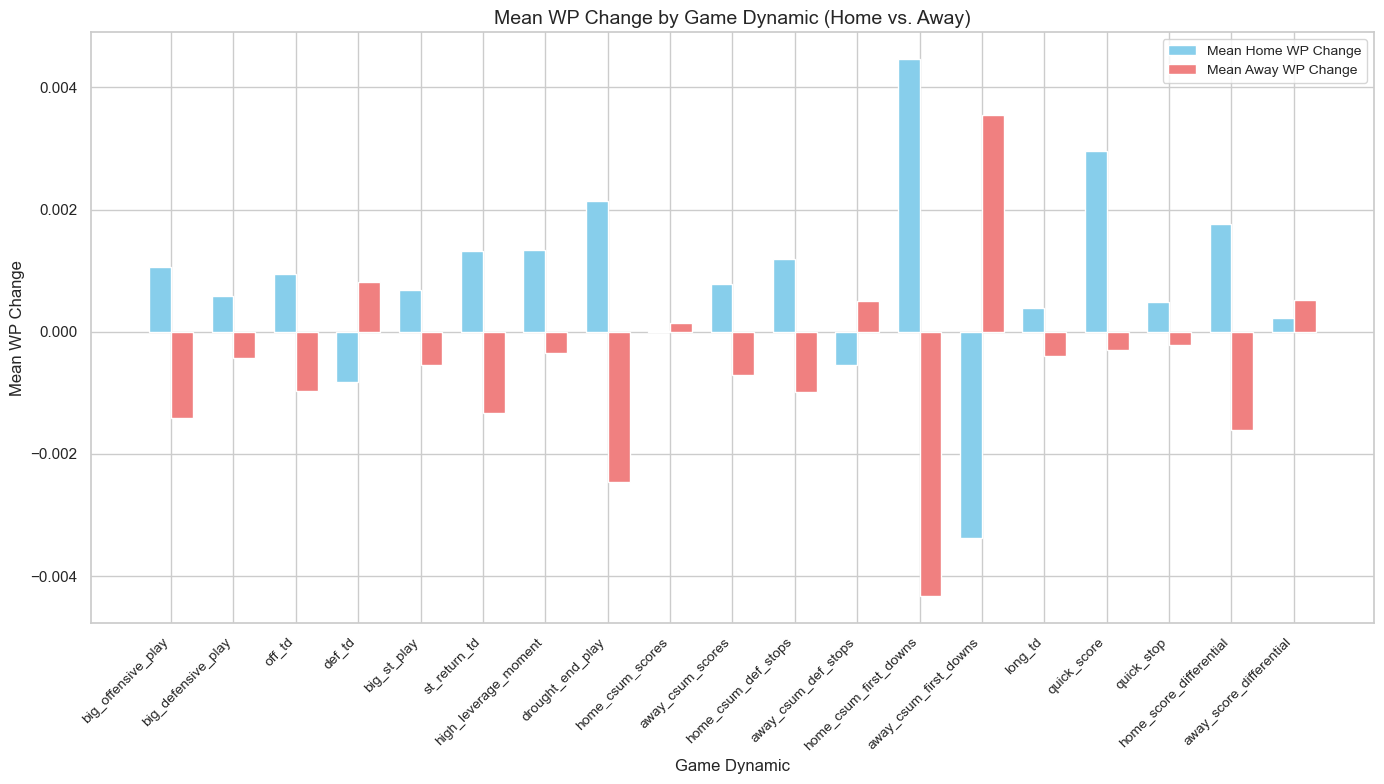

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))
bar_width = 0.35
x = wp_change_analysis_df['game_dynamic']

plt.bar(
    x=np.arange(len(x)) - bar_width / 2,
    height=wp_change_analysis_df['mean_home_wp_change'],
    width=bar_width,
    label='Mean Home WP Change',
    color='skyblue',
)
plt.bar(
    x=np.arange(len(x)) + bar_width / 2,
    height=wp_change_analysis_df['mean_away_wp_change'],
    width=bar_width,
    label='Mean Away WP Change',
    color='lightcoral',
)

plt.xticks(np.arange(len(x)), x, rotation=45, ha='right', fontsize=10)
plt.xlabel('Game Dynamic', fontsize=12)
plt.ylabel('Mean WP Change', fontsize=12)
plt.title('Mean WP Change by Game Dynamic (Home vs. Away)', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()

plt.show()

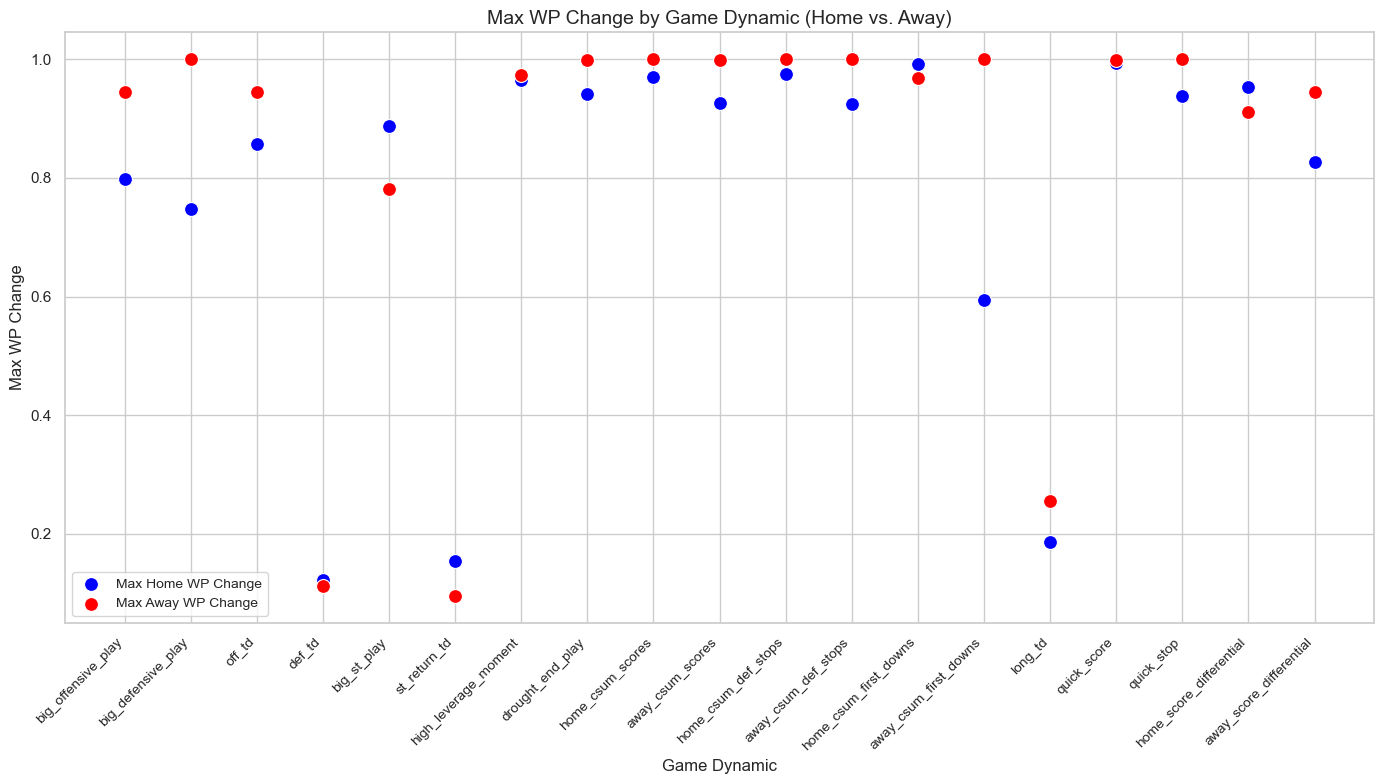

In [43]:
plt.figure(figsize=(14, 8))

sns.scatterplot(
    x='game_dynamic',
    y='max_home_wp_change',
    data=wp_change_analysis_df,
    color='blue',
    s=100,
    label='Max Home WP Change',
)
sns.scatterplot(
    x='game_dynamic',
    y='max_away_wp_change',
    data=wp_change_analysis_df,
    color='red',
    s=100,
    label='Max Away WP Change',
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Game Dynamic', fontsize=12)
plt.ylabel('Max WP Change', fontsize=12)
plt.title('Max WP Change by Game Dynamic (Home vs. Away)', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()

plt.show()

# Specific things to investigate/visualize: Time-Based, Score-Based, Home/Away-Based, Individual-Dynamic-Based

## Home vs Away similar time/score, similar play with same result, difference in change in wp
## Difference in changes of wp in each quarter
## Difference in changes of wp in 2 score, 1 score, and tied situations
## Difference in changes of wp for 1,2,3 consecutive scores
## Difference in changes of wp for /away TD

### Need too eventually combine multiple of these dynamics to really dig deep... Home, 4th quarter, 1 score game check the difference between offensive and defensive touchdowns, and the same for away and vice versa for both etc.

### Also Scatterplots of many of the dynamic features showing the home and away changes in wp like above, also need to  be combined with things like different quarters, different score differential, time remaining etc